In [1]:
import pandas as pd,numpy as np
from glob import glob
import os,re
from tqdm import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool
import seaborn as sns

In [7]:
# Make a bed file with all of the LINE1 mutations
TE='Alu' # Alu or L1
TE="RefL1_multi"

# df = pd.read_csv('rmsk_hg38.L1.gtf.gz',sep='\t',names=['chr','.','exon','start','end','evolutionary age','strand','-','info'])

# # df=df['info'].str.split(';',expand=True)
# df['L1 class']=df['info'].str.extract('gene_id \"(.*)\"; transcript_id')
# df['svlen'] = df['end']-df['start']

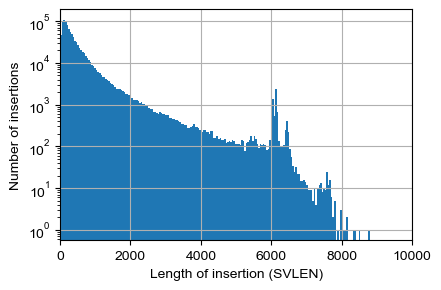

In [7]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
df['svlen'].plot(kind='hist', bins=200)
plt.xlabel('Length of insertion (SVLEN)')
plt.ylabel('Number of insertions')
plt.grid()
plt.xlim([0,10000])
plt.yscale('log')

# plt.subplot(1,2,2)
# df['svlen'].plot(kind='hist', bins=np.arange(0,2e8,1e7))
# plt.xlabel('Length of insertion (SVLEN)')
# plt.ylabel('Number of insertions')
# plt.grid()
# plt.ylim([0,200])

In [8]:
df['full length']=(df['svlen']>5000)

In [9]:
L1_order=df.groupby('L1 class')['evolutionary age'].mean().sort_values().index[::-1]

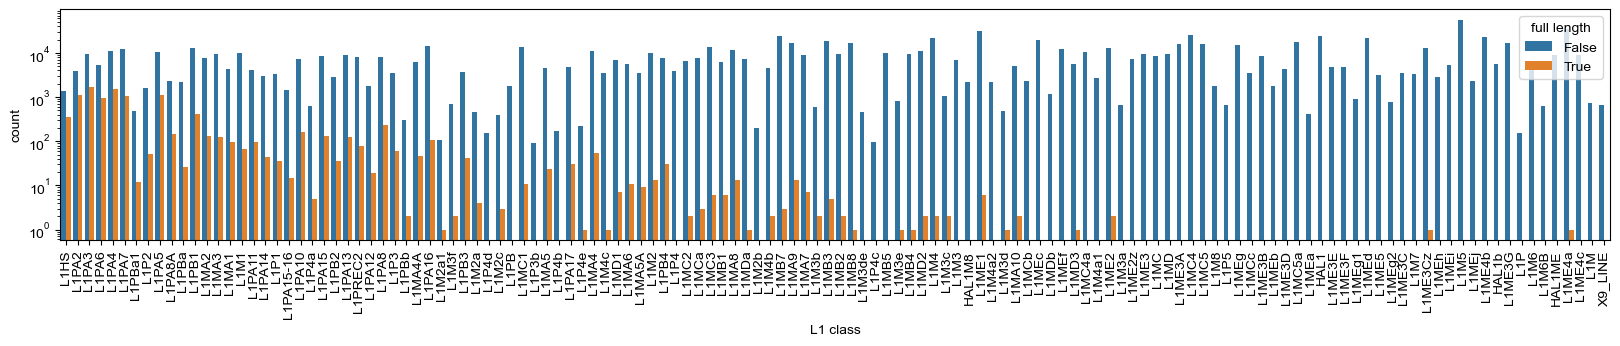

In [10]:
plt.figure(figsize=(20,3))
sns.countplot(data=df,x='L1 class', hue='full length',order=L1_order)
plt.xticks(rotation=90);
plt.yscale('log')
# plt.savefig('Plots/Number_of_ReferenceL1s_by_class.pdf')

In [11]:
# Keep only full length
df = df[df['svlen']>5000]
chroms=[f'chr{i}' for i in np.arange(1,23)]+['chrX']
df=df[df['chr'].isin(chroms)]
df

,chr,.,exon,start,end,evolutionary age,strand,-,info,L1 class,svlen,full length
96,chr1,hg38_rmsk,exon,100199603,100206088,22308,+,.,"gene_id ""L1PA7""; transcript_id ""L1PA7_dup342"";...",L1PA7,6485,True
245,chr1,hg38_rmsk,exon,100598239,100604384,25226,-,.,"gene_id ""L1PA5""; transcript_id ""L1PA5_dup292"";...",L1PA5,6145,True
253,chr1,hg38_rmsk,exon,100632239,100638390,25354,-,.,"gene_id ""L1PA3""; transcript_id ""L1PA3_dup292"";...",L1PA3,6151,True
257,chr1,hg38_rmsk,exon,100646492,100651884,16165,+,.,"gene_id ""L1PA11""; transcript_id ""L1PA11_dup115...",L1PA11,5392,True
264,chr1,hg38_rmsk,exon,100662982,100669120,25118,-,.,"gene_id ""L1PA4""; transcript_id ""L1PA4""; family...",L1PA4,6138,True
...,...,...,...,...,...,...,...,...,...,...,...,...
992106,chrX,hg38_rmsk,exon,99519470,99525410,14965,+,.,"gene_id ""L1PB3""; transcript_id ""L1PB3_dup2171""...",L1PB3,5940,True
992264,chrX,hg38_rmsk,exon,99761519,99767896,19261,+,.,"gene_id ""L1MA1""; transcript_id ""L1MA1_dup2675""...",L1MA1,6377,True
992269,chrX,hg38_rmsk,exon,99771822,99777666,16015,-,.,"gene_id ""L1MA1""; transcript_id ""L1MA1_dup2676""...",L1MA1,5844,True
992288,chrX,hg38_rmsk,exon,99805557,99811344,26399,+,.,"gene_id ""L1PA5""; transcript_id ""L1PA5_dup7061""...",L1PA5,5787,True


In [12]:
bedfile = df.groupby(['chr','start','end','strand','L1 class'])[['svlen']].agg({'svlen':'median'}).reset_index()
bedfile['name']=f'{TE}_'+bedfile.index.astype(str)
bedfile['score']='.'

In [10]:
bedfile['5prime']=bedfile['start']
bedfile.loc[bedfile['strand']=='-','5prime']=bedfile.loc[bedfile['strand']=='-','end']-1

In [11]:
bedfile=bedfile[['chr', 'start', 'end', 'strand', 'svlen', 'name', 'score','L1 class','5prime']]
bedfile.to_csv(f'xtea_{TE}_all_KNRGL.bed',header=None,index=False,sep='\t')

In [12]:
binsize=128
nbins=100
bed_bins=[]
for mybin in np.arange(-nbins,nbins):
  mybed = bedfile.copy()
  mybed['start']=mybed['5prime']+(mybin*binsize)
  mybed['end']=mybed['5prime']+(mybin+1)*binsize
  mybed['name'] = mybed['name'].str.extract(r'('+TE+'_[0-9]+)',expand=True)
  mybed.loc[mybed['strand']=='+','name'] += f'_bin{mybin*binsize}'
  mybed.loc[mybed['strand']=='-','name'] += f'_bin{-(mybin+1)*binsize}'
  bed_bins.append(mybed)

In [13]:
bed_bins_df = pd.concat(bed_bins)
bed_bins_df=bed_bins_df.sort_values(['chr','start','strand'])
bed_bins_df[['chr','start','end','name','score','strand','svlen']].to_csv(f'xtea_{TE}_all_KNRGL.bins.bed',sep='\t',header=False,index=False)
os.system(f'bgzip -f xtea_{TE}_all_KNRGL.bins.bed && tabix xtea_{TE}_all_KNRGL.bins.bed.gz ');

NameError: name 'bed_bins' is not defined

In [14]:
# Create merged bed file with the regions
!zcat xtea_{TE}_all_KNRGL.bins.bed.gz  | bedtools merge -i - > xtea_{TE}_all_KNRGL.bins.merged.bed

bins=pd.read_csv(f'xtea_{TE}_all_KNRGL.bins.merged.bed', sep='\t',header=None)
bins[0]=bins[0].str.replace('chr','')
bins.to_csv(f'xtea_{TE}_all_KNRGL.bins.merged.no_chr.bed',sep='\t',index=False,header=False)
! cat xtea_{TE}_all_KNRGL.bins.merged.bed xtea_{TE}_all_KNRGL.bins.merged.no_chr.bed > foo && mv foo xtea_{TE}_all_KNRGL.bins.merged.bed

In [252]:
!wc -l xtea_{TE}_all_KNRGL.bins.merged.bed

17320 xtea_RefL1_multi_all_KNRGL.bins.merged.bed


In [3]:
# metadata=pd.read_csv('/datasets/Public_Datasets/Dracheva_PsychEncode_development/processed/PEC_LIMS_11042022_mod.csv')
# metadata=pd.read_csv('../PsychENCODE and SCZ sample metadata - PEC_RNAmeta.csv')
metadata=pd.read_csv('../PsychENCODE and SCZ sample metadata - Totalmeta (1).csv')
metadata['AGEDAYS']=metadata['AGEDAYS'].fillna(365/2)
metadata['age'] = metadata['AGEYEARS']+metadata['AGEDAYS']/365

age_periods = {'infancy':[0,1], 'early_child':[1,5],'late_child':[5,12],'adolescence':[12,20],'adult':[20,50],'late_adult':[50,200]}
metadata['age_period']=np.nan
for j in age_periods:
  age_lims=age_periods[j]
  metadata.loc[(metadata['age']>=age_lims[0])&(metadata['age']<age_lims[1]),'age_period'] = j
metadata['age_period'].value_counts()

adult          36
late_adult     26
adolescence    16
early_child    12
infancy         6
late_child      6
Name: age_period, dtype: int64

In [6]:
metadata

,Sample ID,Brain Bank,DISORDER,CDEATHOFF,AGEYEARS,AGEDAYS,sex,race,Brain PH,PMI Hours,...,DNA Methylation,methyl_GABA,methyl_GLU,RNA Seq,RNA_GABA,RNA_GLU,WGS,dataset,age,age_period
0,390,University of Maryland Brain and Tissue Bank(U...,Unaffected Control,Asphyxia,0,125.0,Female,White,5.74,18.0,...,Yes,Yes,Yes,No,No,No,Yes,PEC,0.342466,infancy
1,1105,University of Maryland Brain and Tissue Bank(U...,Unaffected Control,Multiple Injuries,16,341.0,Male,White,5.13,17.0,...,No,No,No,Yes,Yes,Yes,No,PEC,16.934247,adolescence
2,1133,University of Maryland Brain and Tissue Bank(U...,Unaffected Control,Cocaine intoxication,38,178.0,Male,White,5.45,9.0,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,PEC,38.487671,adult
3,1134,University of Maryland Brain and Tissue Bank(U...,Unaffected Control,ASCVD (Arteriosclerotic Cardiovascular Disease),41,252.0,Male,White,5.89,15.0,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,PEC,41.690411,adult
4,1275,University of Maryland Brain and Tissue Bank(U...,Unaffected Control,Acute Myocarditis,2,58.0,Female,Black or African-American,5.39,21.0,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,PEC,2.158904,early_child
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,323,NaN,S,Fall from height (suicide),54,182.5,Female,NaN,6.79,10.0,...,Yes,No,Yes,No,No,No,Yes,SCZ,54.500000,late_adult
98,326,NaN,C,Pedestrian struck by motor vehicle (accident),14,182.5,Female,NaN,6.92,17.0,...,Yes,Yes,Yes,No,No,No,Yes,SCZ,14.500000,adolescence
99,S03-0019,NaN,C,NaN,51,182.5,Female,NaN,6.1,11.0,...,No,No,No,No,No,No,Yes,SCZ,51.500000,late_adult
100,S04-0170,NaN,C,NaN,57,182.5,Male,NaN,6.7,19.0,...,No,No,No,No,No,No,Yes,SCZ,57.500000,late_adult


In [240]:
# Use tabix to extract the portions of allc tables from the KNRGL regions.
# This will speed up subsequent processing to calculate the binned data
# datadir='/cndd2/jchien/project/CZI_human/pseudobulk_allc/allc_rmSNPs'
datadir='/datasets/Public_Datasets/Dracheva_PsychEncode_development/processed/'

allc_files=glob(f'{datadir}/allc*/allc_*_hisat3n.tsv.gz')

In [265]:
if not os.path.exists(f'/scratch/allc_{TE}_regions'):
  os.mkdir(f'/scratch/allc_{TE}_regions')
  
def do_tabix(allc):
  # Extract regions using tabix
  sample=re.match(r'.*processed/allc_.*hisat3n/allc_(.*)_hisat3n\.tsv\.gz',allc).group(1)
  if os.path.exists(f'/scratch/allc_{TE}_regions/allc_{TE}_KNRGL.{sample}.tsv.gz.tbi'):
#     print(f'Skipping /scratch/allc_{TE}_regions/allc_{TE}_KNRGL.{sample}.tsv.gz')
    return 0
  os.system(f'touch /scratch/allc_{TE}_regions/allc_{TE}_KNRGL.{sample}.tsv.gz.tbi')
  cmd=f'tabix -R xtea_{TE}_all_KNRGL.bins.merged.bed {allc} | '
  cmd+=" awk '{OFS=\"\\t\"; if ($1!~/chr/) {$1=\"chr\"$1}; print $0;}' | "# Make sure the chromosome scaffold name has "chr"
  cmd+=f' bgzip -c  > /scratch/allc_{TE}_regions/allc_{TE}_KNRGL.{sample}.tsv.gz'
  os.system(cmd)
  os.system(f'/home/emukamel/mambaforge/envs/allcools/bin/allcools tabix-allc --reindex /scratch/allc_{TE}_regions/allc_{TE}_KNRGL.{sample}.tsv.gz >> tabix.log')
  
  return 0

In [266]:
with Pool(6) as p:
  x=list(tqdm(p.imap(do_tabix, allc_files),total=len(allc_files)))

100%|██████████| 232/232 [07:00<00:00,  1.81s/it]


In [269]:
# Note: Some samples seem to have the wrong chromosome naming convention. These are in the "set1remap" folder

In [270]:
hg38=pd.read_csv('/cndd/Public_Datasets/references/hg38/hg38.genome',sep='\t',names=['chr','len'])
hg38=hg38.set_index('chr')
hg38=hg38.loc[[f'chr{i+1}' for i in range(22)]+['chrX','chrY']]
hg38.to_csv('hg38.genome',sep='\t',header=False)

In [271]:
os.path.exists(f'/scratch/binc_{TE}_regions')

True

In [272]:
%%time
# Use allcools to calculate the binned mC level 
datadir=f'/scratch/allc_{TE}_regions/'
allc_files=glob(f'{datadir}/allc_{TE}_KNRGL.*.tsv.gz')
genome='hg38.sorted.genome'
bed=f'xtea_{TE}_all_KNRGL.bins.bed.gz'

def allc2bins(allc):
  sample=allc.split('/')[-1]
  sample=re.match(r'allc_'+TE+'_KNRGL\.(.*)\.tsv.gz',sample).group(1)
  assert type(sample) is str
  outfile=f'/scratch/binc_{TE}_regions/binc.{sample}'
  if not os.path.exists(f'/scratch/binc_{TE}_regions'):
    os.mkdir(f'/scratch/binc_{TE}_regions')
  if os.path.exists(f'{outfile}.lock'):
    with open('allcools.log','a') as f:
      f.write(f'Sample already processed, skipping {sample}\n')
    print(f'Sample already processed, skipping {sample}\n')
  else:
    os.system(f'touch {outfile}.lock')
    bed=f'xtea_{TE}_all_KNRGL.bins.bed.gz'
    cmd=f'/home/emukamel/mambaforge/envs/allcools/bin/allcools allc-to-region-count '
    cmd+=f' --allc_path {allc} --chrom_size_path {genome}'
    cmd+=f' --output_prefix {outfile} '
    cmd+=f' --mc_contexts CGN CHN'
    cmd+=f' --region_bed_paths {bed} --region_bed_names all_{TE}_KNRGL '
    cmd+=f' --cpu 1 >> allcools.log'
    os.system(cmd)
  return 0

with Pool(6) as p:
  x=list(tqdm(p.imap(allc2bins, allc_files),total=len(allc_files)))


  0%|          | 0/232 [00:00<?, ?it/s]

Sample already processed, skipping 6007_Glu_OxBS_S31
Sample already processed, skipping 4670-Glu-OxBS
Sample already processed, skipping 4321-Glu-BS



Sample already processed, skipping 5446-GABA-oxBS

Sample already processed, skipping 5918-Glu-OxBS
Sample already processed, skipping 1823-GABA-OxBS


Sample already processed, skipping 1133-Glu-oxBS
Sample already processed, skipping 4337-Glu-BS


Sample already processed, skipping 4670-Glu-BS
Sample already processed, skipping 4428-GABA-OxBS


Sample already processed, skipping 5643-GABA-BS

Sample already processed, skipping HCT17HEIA010-GABA-oxBS

Sample already processed, skipping 1823-GABA-BS

Sample already processed, skipping HCTZZNA014-GABA-oxBS

Sample already processed, skipping 5086-GABA-oxBS

Sample already processed, skipping HCTYPA008_GABA_OxBS_S36

Sample already processed, skipping 4337-GABA-BS

Sample already processed, skipping 5976-Glu-BS

Sample already processed, skipping 4321-Glu-OX

Sample already processed, ski


 16%|█▌        | 37/232 [04:38<19:07,  5.89s/it]   

Sample already processed, skipping HCT16HCQA020-GABA-OxBS

Sample already processed, skipping 1864-Glu-OX

Sample already processed, skipping HCT17HEIA010-GABA-BS

Sample already processed, skipping HCT15HAWA031-GABA-BS

Sample already processed, skipping 198034-1435-GABA-BS

Sample already processed, skipping HCTZZNA014-Glu-BS




 16%|█▋        | 38/232 [06:32<32:08,  9.94s/it]

Sample already processed, skipping 4428-GABA-BS

Sample already processed, skipping 5401-GABA-BS

Sample already processed, skipping 5408-Glu-OxBS

Sample already processed, skipping 4422_Glu_BS_S7

Sample already processed, skipping 4425-GABA-oxBS

Sample already processed, skipping 1648-Glu-OxBS

Sample already processed, skipping 5744-GABA-oxBS

Sample already processed, skipping 4332_Glu_BS_S17

Sample already processed, skipping 6032-GABA-oxBS

Sample already processed, skipping 5976-GABA-BS

Sample already processed, skipping 5977-Glu-OX

Sample already processed, skipping 5387-Glu-BS

Sample already processed, skipping 198034-1435-Glu-OxBS

Sample already processed, skipping 390-GABA-BS

Sample already processed, skipping 5293-Glu-BS

Sample already processed, skipping 179134-1401-Glu-OxBS

Sample already processed, skipping 4336_GABA_BS_S16

Sample already processed, skipping 1134-Glu-oxBS

Sample already processed, skipping HCT16HCQA020-GABA-BS

Sample already processed, skipp


 20%|██        | 47/232 [06:34<20:52,  6.77s/it]

Sample already processed, skipping HCT16HCQA020-Glu-OxBS

Sample already processed, skipping HCT15HBNA032-Glu-BS

Sample already processed, skipping HCTYPA008_GABA_BS_S14

Sample already processed, skipping 5408-GABA-OxBS

Sample already processed, skipping HCTZZHA019_Glu_BS_S21

Sample already processed, skipping 5451-Glu-oxBS

Sample already processed, skipping 179134-1401-Glu-BS

Sample already processed, skipping 75979-Glu-BS




 23%|██▎       | 54/232 [06:44<15:53,  5.36s/it]

Sample already processed, skipping 1823-Glu-BS

Sample already processed, skipping 1241-Glu-BS

Sample already processed, skipping 198034-1435-Glu-BS

Sample already processed, skipping 4422_Glu_OxBS_S29

Sample already processed, skipping 1790-Glu-oxBS

Sample already processed, skipping 4414-GABA-OxBS

Sample already processed, skipping 5977-Glu-BS

Sample already processed, skipping 4379_Glu_OxBS_S41

Sample already processed, skipping 4336_Glu_OxBS_S37

Sample already processed, skipping 5293-GABA-OxBS



 25%|██▌       | 59/232 [06:51<13:01,  4.52s/it]


 31%|███       | 71/232 [07:55<13:01,  4.85s/it]

Sample already processed, skipping 4411-Glu-BS

Sample already processed, skipping 5643-Glu-OxBS

Sample already processed, skipping 5617-GABA-OX

Sample already processed, skipping 198035-1765_GABA_BS_S12

Sample already processed, skipping 5976-Glu-OX

Sample already processed, skipping HCT15HBMA007-Glu-BS

Sample already processed, skipping HCTYPA008_Glu_OxBS_S35

Sample already processed, skipping 5787-GABA-OxBS

Sample already processed, skipping HCT16HCQA020-Glu-BS




 47%|████▋     | 108/232 [09:48<07:37,  3.69s/it]

Sample already processed, skipping 4379_GABA_OxBS_S42

Sample already processed, skipping 4422_GABA_BS_S8

Sample already processed, skipping 5077-GABA-OxBS

Sample already processed, skipping 4369-GABA-OxBS

Sample already processed, skipping 5086-Glu-oxBS

Sample already processed, skipping 4782-Glu-oxBS

Sample already processed, skipping 5977-GABA-OX

Sample already processed, skipping 6007_GABA_OxBS_S32

Sample already processed, skipping 5918-Glu-BS

Sample already processed, skipping 4321-GABA-BS




 50%|█████     | 117/232 [09:52<05:56,  3.10s/it]

Sample already processed, skipping 4670-GABA-OxBS

Sample already processed, skipping 5643-Glu-BS

Sample already processed, skipping 390-Glu-BS




 51%|█████     | 118/232 [10:06<06:26,  3.39s/it]

Sample already processed, skipping 5744-Glu-oxBS

Sample already processed, skipping 1275-GABA-OX

Sample already processed, skipping 1275-GABA-BS

Sample already processed, skipping 5077-GABA-BS

Sample already processed, skipping 6285-Glu-oxBS

Sample already processed, skipping 198034-1435-GABA-OxBS

Sample already processed, skipping 1133-GABA-oxBS

Sample already processed, skipping 390-GABA-OX

Sample already processed, skipping 390-Glu-OX

Sample already processed, skipping 4336_GABA_OxBS_S38

Sample already processed, skipping 4428-Glu-BS

Sample already processed, skipping 5293-GABA-BS

Sample already processed, skipping 4782-GABA-OX

Sample already processed, skipping 5606-GABA-BS

Sample already processed, skipping 1277_GABA_BS_S4




 55%|█████▌    | 128/232 [10:08<04:17,  2.48s/it]

Sample already processed, skipping HCT15HBNA032-Glu-oxBS

Sample already processed, skipping 5606-Glu-BS

Sample already processed, skipping HCT15HBNA032-GABA-BS

Sample already processed, skipping 5184-Glu-oxBS

Sample already processed, skipping 4369-Glu-BS

Sample already processed, skipping 5408-GABA-BS

Sample already processed, skipping 75979-GABA-BS

Sample already processed, skipping 5617-Glu-BS

Sample already processed, skipping 5918-GABA-BS

Sample already processed, skipping 4379_GABA_BS_S20

Sample already processed, skipping 6285-GABA-oxBS

Sample already processed, skipping HCT15HBMA007-GABA-BS

Sample already processed, skipping 5936-GABA-BS

Sample already processed, skipping 1241-Glu-OX

Sample already processed, skipping 1277-Glu-oxBS

Sample already processed, skipping 4413-Glu-OxBS

Sample already processed, skipping 4425-Glu-BS

Sample already processed, skipping 4411-GABA-OX



 60%|██████    | 140/232 [10:51<04:31,  2.95s/it]

Sample already processed, skipping 75979-Glu-OxBS

Sample already processed, skipping 198035-1765_Glu_BS_S11

Sample already processed, skipping 5918-GABA-OxBS

Sample already processed, skipping 4414-Glu-OxBS

Sample already processed, skipping 1275-Glu-BS

Sample already processed, skipping 4413-Glu-BS

Sample already processed, skipping HCT15HAWA031-GABA-oxBS

Sample already processed, skipping 4379_Glu_BS_S19

Sample already processed, skipping 5401-Glu-oxBS

Sample already processed, skipping 4414-GABA-BS

Sample already processed, skipping HCTZZHA019_Glu_OxBS_S43

Sample already processed, skipping HCT15HBMA007-GABA-OxBS

Sample already processed, skipping 5787-Glu-BS

Sample already processed, skipping 5787-GABA-BS

Sample already processed, skipping HCT17HEIA010-GLU-oxBS

Sample already processed, skipping 4332_Glu_OxBS_S39

Sample already processed, skipping 4422_GABA_OxBS_S30

Sample already processed, skipping 1275-Glu-OX

Sample already processed, skipping 1790-GABA-OX

Sam


 65%|██████▌   | 151/232 [13:06<08:29,  6.29s/it]

Sample already processed, skipping 5184-GABA-oxBS

Sample already processed, skipping HCT16HECA028-Glu-BS




 67%|██████▋   | 155/232 [13:22<07:36,  5.93s/it]

Sample already processed, skipping 5387-GABA-OxBS

Sample already processed, skipping 5077-Glu-BS

Sample already processed, skipping 5606-Glu-OX




 74%|███████▎  | 171/232 [13:23<03:11,  3.15s/it]

Sample already processed, skipping 4411-GABA-BS

Sample already processed, skipping 5408-Glu-BS

Sample already processed, skipping 1790-GABA-BS

Sample already processed, skipping HCTZZHA019_GABA_OxBS_S44

Sample already processed, skipping 174052-1241-GABA-oxBS

Sample already processed, skipping 1277_GABA_OxBS_S26

Sample already processed, skipping 5446-Glu-oxBS

Sample already processed, skipping 4670-GABA-BS

Sample already processed, skipping 1648-Glu-BS

Sample already processed, skipping HCT16HECA028-GABA-oxBS

Sample already processed, skipping 6007_GABA_BS_S10

Sample already processed, skipping 75979-GABA-OxBS



100%|██████████| 232/232 [16:35<00:00,  4.29s/it]


CPU times: user 317 ms, sys: 4.61 s, total: 4.93 s
Wall time: 16min 41s


In [273]:
# Move the files
# ! rsync -av /scratch/allc_regions/binc.* /cndd/emukamel/CZI_human_interindividual/Line1_mC/binc/

In [8]:
# Load the binned mC data
mc_files=glob(f'/scratch/binc_{TE}_regions/binc*CGN-Both.sparse.bed.gz')
samples_celltypes=[]
for mc_file in mc_files:
  sample=re.match(f'.*binc\.(.*)\.all_{TE}_KNRGL_CGN-Both\.sparse\.bed\.gz',mc_file).group(1)
  samples_celltypes.append(sample)
len(samples_celltypes)

232

In [275]:
bed_bins_df_name=bed_bins_df.set_index(['chr','start','end'])['name']
bed_bins_df_name.name='bin_id'

In [276]:
bed_bins_df_name=bed_bins_df_name[~bed_bins_df_name.index.duplicated()]
bed_bins_df_name.index.duplicated().any()

False

In [130]:
samples_celltypes=pd.Series(samples_celltypes)

df_files=pd.DataFrame({'samples_celltypes':samples_celltypes})
# df_files['sample'] = df_files['samples_celltypes'].str.extract(r'^(.*)-(Glu|GABA).*',expand=False)
# pd.Series.str.extract?
df_files['sample']=df_files['samples_celltypes'].str.extract(r'^(.*)[-_](Glu|GABA|GLU).*',expand=False)[0].str.upper()
df_files['sample']=df_files['sample'].str.replace('/','-')
df_files['celltype']=df_files['samples_celltypes'].str.extract(r'^(.*)[-_](Glu|GABA|GLU).*',expand=False)[1].str.upper()
df_files['mctype']=df_files['samples_celltypes'].str.extract(r'^(.*)[-_](Glu|GABA|GLU)[-_](BS|OxBS|oxBS|OX)',expand=False)[2]
df_files.loc[df_files['mctype'].str.upper()!='BS','mctype']='OxBS'

# Merge binc files across all donors for each age period

In [227]:
# Combine binc files
df_files['used']=0
for age_period in metadata['age_period'].unique():
  samples=metadata.loc[(metadata['age_period']==age_period),'Sample ID'].str.upper().str.replace('/','-').unique()
  samples[samples=='174052-1241']='1241'
  for celltype in ['GLU','GABA']:
    for mctype in ['BS','OxBS']:
      my_samples=(df_files['sample'].isin(samples))&(df_files['celltype']==celltype)&(df_files['mctype']==mctype)
      
      df_files.loc[my_samples,'used']+=1
      
      for ctxt in ['CGN','CHN']:
        dfs=[]
        for sample in samples:
          s=df_files.loc[(df_files['sample']==sample)&(df_files['celltype']==celltype)&(df_files['mctype']==mctype),'samples_celltypes'].values
          if len(s)==0:
            continue
          assert len(s)==1
          s=s[0]
          binc_file=f'/scratch/binc_{TE}_regions/binc.{s}.all_{TE}_KNRGL_{ctxt}-Both.sparse.bed.gz'
          assert os.path.exists(binc_file)
          my_df=pd.read_csv(binc_file,sep='\t',
                            names=['chr','start','end','l1_id','.','strand','svlen','mc','h'],
                            index_col=['chr','start','end','l1_id','.','strand','svlen']
                           ).stack()
          dfs.append(my_df)
        binc=pd.DataFrame(dfs).sum(axis=0).unstack()
        binc=binc[['mc','h']].astype(int)
        binc=binc.reset_index()
        print(f'Saving /scratch/binc_{TE}_combined_regions/binc.{age_period}-{celltype}-{mctype}.all_{TE}_KNRGL_{ctxt}-Both.sparse.bed.gz')
        binc.to_csv(f'/scratch/binc_{TE}_combined_regions/binc.{age_period}-{celltype}-{mctype}.all_{TE}_KNRGL_{ctxt}-Both.sparse.bed.gz',
                    sep='\t',
                   index=False,header=False)

Saving /scratch/binc_RefL1_multi_combined_regions/binc.infancy-GLU-BS.all_RefL1_multi_KNRGL_CGN-Both.sparse.bed.gz
Saving /scratch/binc_RefL1_multi_combined_regions/binc.infancy-GLU-BS.all_RefL1_multi_KNRGL_CHN-Both.sparse.bed.gz
Saving /scratch/binc_RefL1_multi_combined_regions/binc.infancy-GLU-OxBS.all_RefL1_multi_KNRGL_CGN-Both.sparse.bed.gz
Saving /scratch/binc_RefL1_multi_combined_regions/binc.infancy-GLU-OxBS.all_RefL1_multi_KNRGL_CHN-Both.sparse.bed.gz
Saving /scratch/binc_RefL1_multi_combined_regions/binc.infancy-GABA-BS.all_RefL1_multi_KNRGL_CGN-Both.sparse.bed.gz
Saving /scratch/binc_RefL1_multi_combined_regions/binc.infancy-GABA-BS.all_RefL1_multi_KNRGL_CHN-Both.sparse.bed.gz
Saving /scratch/binc_RefL1_multi_combined_regions/binc.infancy-GABA-OxBS.all_RefL1_multi_KNRGL_CGN-Both.sparse.bed.gz
Saving /scratch/binc_RefL1_multi_combined_regions/binc.infancy-GABA-OxBS.all_RefL1_multi_KNRGL_CHN-Both.sparse.bed.gz
Saving /scratch/binc_RefL1_multi_combined_regions/binc.adolescence-G

In [280]:
min_coverage=5 # Minimum coverage per bin
maxbin=200000

# for sample_celltype in tqdm(samples_celltypes):
def get_binc(sample_celltype):
  sample=re.match(r'^(.*)[-_](Glu|GLU|GABA).*',sample_celltype).group(1)
  celltype=re.match(r'^(.*)[-_](Glu|GLU|GABA).*',sample_celltype).group(2)
  mctype=re.match(r'^(.*)[-_](Glu|GLU|GABA)[-_](BS|OxBS|OX|oxBS).*',sample_celltype).group(3)

  dfs=[]
  for ctxt in ['CGN','CHN']:
    
    df=pd.read_csv(f'/scratch/binc_{TE}_combined_regions/binc.{sample_celltype}.all_{TE}_KNRGL_{ctxt}-Both.sparse.bed.gz',
                   sep='\t',header=None,
                   usecols=[3,7,8], # NOTE: Column 6 has the SVLEN
                   names=['bin_id','mc','coverage'],
#                    nrows=10000,
                  )
    df=df.reset_index()
    
    df[f'm{ctxt}'] = df['mc']/df['coverage']
    df[f'{TE}_id']=df['bin_id'].str.extract(r'^('+TE+'_[0-9]+)')
    df['bin']=df['bin_id'].str.extract(r'^'+TE+r'_[0-9]+_bin(.*)$').astype(int)
    df = df[df['bin'].abs()<=maxbin]
    
    df['sample']=sample
    df['celltype']=celltype
    df['mctype']=mctype
    df.loc[df['coverage']<min_coverage,f'm{ctxt}']=np.nan
    df=df[[TE+'_id','bin',f'm{ctxt}','sample','celltype','coverage','mctype']].set_index(['sample','celltype','mctype',TE+'_id','bin'])
    df.columns.names=['measure']
    df=df.rename(columns={'coverage':f'coverage-{ctxt}'})
    df=df.unstack(['mctype','sample','celltype'])

    dfs.append(df)
  df=dfs[0].join(dfs[1],how='outer')
  
  return df

In [281]:
# Load the binned mC data
mc_files=glob(f'/scratch/binc_{TE}_combined_regions/binc*CGN-Both.sparse.bed.gz')
age_celltypes=[]
for mc_file in mc_files:
  sample=re.match(f'.*binc\.(.*)\.all_{TE}_KNRGL_CGN-Both\.sparse\.bed\.gz',mc_file).group(1)
  age_celltypes.append(sample)

In [282]:
with Pool(8) as p:
  dfs=list(tqdm(p.imap(get_binc,age_celltypes),total=len(age_celltypes)))

100%|██████████| 24/24 [01:13<00:00,  3.08s/it]


In [283]:
%%time
# Separate the coverage
dfs_coverage = [df.filter(like='coverage') for df in dfs]

CPU times: user 649 ms, sys: 504 ms, total: 1.15 s
Wall time: 1.15 s


In [284]:
%%time
# Separate the non-coverage
dfs_mc = [df.loc[:,['mCGN','mCHN']] for df in dfs]

CPU times: user 137 ms, sys: 172 ms, total: 309 ms
Wall time: 306 ms


In [285]:
%%time
df_mc=dfs_mc[0].join(dfs_mc[1:],how='outer')

CPU times: user 3min 12s, sys: 9.99 s, total: 3min 22s
Wall time: 3min 22s


In [286]:
%%time
df_mc.to_csv(f'binc_{TE}.mC.age_periods.tsv.gz',sep='\t',float_format='%0.4f')

CPU times: user 4min 53s, sys: 638 ms, total: 4min 53s
Wall time: 4min 53s


In [287]:
%%time
df_coverage=dfs_coverage[0].join(dfs_coverage[1:],how='outer')

CPU times: user 2min 19s, sys: 4.22 s, total: 2min 23s
Wall time: 2min 23s


In [288]:
df_coverage=df_coverage.fillna(0).astype(int)

In [ ]:
%%time
df_coverage.to_csv(f'binc_{TE}.coverage.age_periods.tsv.gz',sep='\t')

# Individual donors

Note that the coverage for individual donors is low

In [4]:
min_coverage=5 # Minimum coverage per bin
maxbin=200000

# for sample_celltype in tqdm(samples_celltypes):
def get_binc(sample_celltype):
  sample=re.match(r'^(.*)[-_](Glu|GLU|GABA).*',sample_celltype).group(1)
  celltype=re.match(r'^(.*)[-_](Glu|GLU|GABA).*',sample_celltype).group(2)
  mctype=re.match(r'^(.*)[-_](Glu|GLU|GABA)[-_](BS|OxBS|OX|oxBS).*',sample_celltype).group(3)

  dfs=[]
  for ctxt in ['CGN','CHN']:
    
    df=pd.read_csv(f'/scratch/binc_{TE}_regions/binc.{sample_celltype}.all_{TE}_KNRGL_{ctxt}-Both.sparse.bed.gz',
                   sep='\t',header=None,
                   usecols=[3,7,8], # NOTE: Column 6 has the SVLEN
                   names=['bin_id','mc','coverage'],
#                    nrows=10000
                  )
    df=df.reset_index()
    
    df[f'm{ctxt}'] = df['mc']/df['coverage']
    df[f'{TE}_id']=df['bin_id'].str.extract(r'^('+TE+'_[0-9]+)')
    df['bin']=df['bin_id'].str.extract(r'^'+TE+r'_[0-9]+_bin(.*)$').astype(int)
    df = df[df['bin'].abs()<=maxbin]
    
    df['sample']=sample
    df['celltype']=celltype
    df['mctype']=mctype
    df.loc[df['coverage']<min_coverage,f'm{ctxt}']=np.nan
    df=df[[TE+'_id','bin',f'm{ctxt}','sample','celltype','mctype','coverage']].set_index(['sample','celltype','mctype',TE+'_id','bin'])
    df.columns.names=['measure']
    df=df.rename(columns={'coverage':f'coverage-{ctxt}'})
    df=df.unstack(['sample','celltype','mctype'])

    dfs.append(df)
  df=dfs[0].join(dfs[1],how='outer')
  
  return df

In [10]:
with Pool(8) as p:
  dfs=list(tqdm(p.imap(get_binc,samples_celltypes),total=len(samples_celltypes)))
# dfs=get_binc(samples_celltypes[0])         

100%|██████████| 232/232 [08:38<00:00,  2.24s/it]


In [19]:
dfs[0].keys()

MultiIndex([(        'mCGN', 'HCT16HECA028', 'Glu', 'BS'),
            ('coverage-CGN', 'HCT16HECA028', 'Glu', 'BS'),
            (        'mCHN', 'HCT16HECA028', 'Glu', 'BS'),
            ('coverage-CHN', 'HCT16HECA028', 'Glu', 'BS')],
           names=['measure', 'sample', 'celltype', 'mctype'])

In [23]:
dfs[0]['mCGN']

sample                 HCT16HECA028
celltype                        Glu
mctype                           BS
RefL1_multi_id  bin                
RefL1_multi_0   -10752          NaN
                -10624          NaN
                -10496          NaN
                -9728           NaN
                -9600           NaN
...                             ...
RefL1_multi_999  12160     0.777778
                 12288          NaN
                 12416          NaN
                 12544          NaN
                 12672     1.000000

[1980901 rows x 1 columns]

In [17]:
len(dfs)

232

In [221]:
# for i,sample_celltype in tqdm(enumerate(samples_celltypes),total=len(samples_celltypes)):
#   mctype=re.match(r'^(.*)[-_](Glu|GLU|GABA)[-_](BS|OxBS|OX|oxBS).*',sample_celltype).group(3)
#   dfs[i]=pd.concat([dfs[i]], keys=[mctype], names=['mctype'],axis=1)

205it [00:04, 45.64it/s]


In [223]:
# dfs[0].join(dfs[1],how='outer')

In [279]:
%%time
# Separate the coverage
dfs_coverage = [df.filter(like='coverage') for df in dfs]

CPU times: user 7.37 s, sys: 9.12 s, total: 16.5 s
Wall time: 16.5 s


In [24]:
%%time
# Separate the non-coverage
dfs_mc = [df.loc[:,(slice(None),['mCGN','mCHN'])] for df in dfs]

<timed exec>:2: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`


CPU times: user 10.3 s, sys: 13.4 s, total: 23.7 s
Wall time: 24.1 s


In [27]:
%%time
# df_mc=dfs_mc[0].copy()
# for x in tqdm(dfs_mc[1:]):
#   df_mc=df_mc.join(x,how='outer')
df_mc=dfs_mc[0].join(dfs_mc[1:],how='outer')

KeyboardInterrupt: 

In [282]:
%%time
df_mc.to_csv(f'binc_{TE}.mC.all_samples.tsv.gz',sep='\t',float_format='%0.4f')

CPU times: user 5.29 s, sys: 143 ms, total: 5.43 s
Wall time: 5.49 s


In [283]:
%%time
df_coverage=dfs_coverage[0].join(dfs_coverage[1:],how='outer')
df_coverage=df_coverage.fillna(0).astype(int)

ValueError: Indexes have overlapping values: MultiIndex([('coverage-CGN',        '4428', 'GABA'),
            ('coverage-CHN',        '4428', 'GABA'),
            ('coverage-CGN', '198035-1765',  'Glu'),
            ('coverage-CHN', '198035-1765',  'Glu'),
            ('coverage-CGN',        '5184', 'GABA'),
            ('coverage-CHN',        '5184', 'GABA'),
            ('coverage-CGN',        '5387', 'GABA'),
            ('coverage-CHN',        '5387', 'GABA'),
            ('coverage-CGN',        '5936', 'GABA'),
            ('coverage-CHN',        '5936', 'GABA'),
            ...
            ('coverage-CGN',        '4414',  'Glu'),
            ('coverage-CHN',        '4414',  'Glu'),
            ('coverage-CGN',        '1275',  'Glu'),
            ('coverage-CHN',        '1275',  'Glu'),
            ('coverage-CGN',        '5977', 'GABA'),
            ('coverage-CHN',        '5977', 'GABA'),
            ('coverage-CGN',  'HCTZZNA014',  'Glu'),
            ('coverage-CHN',  'HCTZZNA014',  'Glu'),
            ('coverage-CGN',        '4379',  'Glu'),
            ('coverage-CHN',        '4379',  'Glu')],
           names=['measure', 'sample', 'celltype'], length=230)

In [284]:
%%time
df_coverage.to_csv(f'binc_{TE}.coverage.all_samples.tsv.gz',sep='\t')

CPU times: user 20min 16s, sys: 865 ms, total: 20min 17s
Wall time: 20min 17s


In [117]:
!ln -s xtea_RefL1_multi_all_KNRGL.bed xtea_RefL1_uniquePlusMulti_all_KNRGL.bed

In [237]:
!ls binc_* -lhtr

-rw-r--r-- 1 emukamel domain users 988M Jun 28 23:51 binc_RefL1_multi.mC.all_samples.tsv.gz
-rw-r--r-- 1 emukamel domain users 790M Jun 29 00:33 binc_RefL1_multi.coverage.all_samples.tsv.gz
